In [23]:
import os
import xarray as xr
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, IterableDataset


In [3]:
d = xr.open_dataset('/scratch/smrserraoseabr/Projects/FluvialCO2/results32/simulation_results_realization_32x32_1.nc')

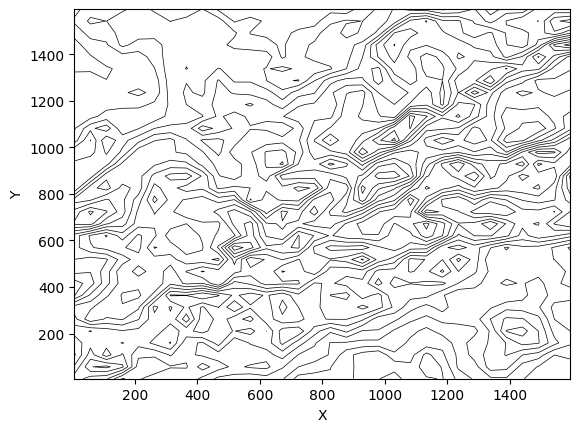

In [22]:
#plot the gridlines
d['Por'].plot.contour(levels=20, colors='k', linewidths=0.5)



In [ ]:
d.Po

In [204]:
class ReadXarrayDatasetNorm(Dataset):
    def __init__(self, folder, input_vars, output_vars, num_files=None):
        self.folder = folder        
        self.file_list = os.listdir(folder)[:num_files] if num_files else os.listdir(folder)            
        self.input_vars = input_vars.copy()
        self.input_vars.append('x_encoding')
        self.input_vars.append('y_encoding')
        self.input_vars.append('time_encoding')
        self.output_vars = output_vars.copy()
        
        self.input_normalizers = []
        self.output_normalizers = []
        self.file_stats = {}



    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder, self.file_list[idx])
        data = xr.open_dataset(file_path)

        X = data['X'].values
        Y = data['Y'].values
        TIME = data['time'].values

        x_mesh, y_mesh = np.meshgrid(data.X, data.Y, indexing='ij')
        TIME_MESH = np.meshgrid(data.time, data.X, data.Y, indexing='ij')
        data = data.assign(x_encoding=xr.DataArray(x_mesh, coords=[("X", X), ("Y", Y)]))
        data = data.assign(y_encoding=xr.DataArray(y_mesh, coords=[("X", X), ("Y", Y)]))
        data = data.assign(time_encoding=xr.DataArray(TIME_MESH[0], coords=[("time", TIME), ("X", X), ("Y", Y)]))
        
        input_data = []
        for var in self.input_vars:
            if 'time' in data[var].dims and 'X' in data[var].dims and 'Y' in data[var].dims:
                input_data.append(torch.tensor(data[var].values, dtype=torch.float32))
            elif 'X' in data[var].dims and 'Y' in data[var].dims:
                scalar_matrix = torch.tensor(data[var].values, dtype=torch.float32) 
                scalar_matrix = scalar_matrix.unsqueeze(0).expand(data.time.size, -1, -1)
                input_data.append(scalar_matrix)
            elif 'time' in data[var].dims:
                scalar_matrix = torch.tensor(data[var][0].values, dtype=torch.float32) 
                scalar_matrix = scalar_matrix.unsqueeze(-1).unsqueeze(-1).expand(-1, data.X.size, data.Y.size)
                input_data.append(scalar_matrix)
                
        #print(len(input_data))

        output_data = []
        for var in self.output_vars:
           output_data.append(torch.tensor(data[var].values, dtype=torch.float32))

        #print(output_data)


        input_data = torch.stack(input_data, dim=-1)
        output_data = torch.stack(output_data, dim=-1)
        

        
       # Compute mean and std if they have not been computed yet
        if file_path not in self.file_stats:
            input_mean = torch.mean(input_data, dim=(0, 1, 2))
            input_std = torch.std(input_data, dim=(0, 1, 2))
            output_mean = torch.mean(output_data, dim=(0, 1, 2))
            output_std = torch.std(output_data, dim=(0, 1, 2))
            self.file_stats[file_path] = {'input_mean': input_mean, 'input_std': input_std, 
                                          'output_mean': output_mean, 'output_std': output_std}
        else:
            input_mean = self.file_stats[file_path]['input_mean']
            input_std = self.file_stats[file_path]['input_std']
            output_mean = self.file_stats[file_path]['output_mean']
            output_std = self.file_stats[file_path]['output_std']

        input_normalizer = UnitGaussianNormalizer(input_data, input_mean, input_std)
        output_normalizer = UnitGaussianNormalizer(output_data, output_mean, output_std)

        normalized_input = input_normalizer.encode(input_data.clone())
        normalized_output = output_normalizer.encode(output_data.clone())

        return input_data, output_data, normalized_input, normalized_output, input_normalizer, output_normalizer




In [205]:
class UnitGaussianNormalizer(object):
    def __init__(self, x, mean=None, std=None, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()
        
        # If mean and std are provided, use them. Otherwise, compute from data.
        if mean is None or std is None:
            self.mean = torch.mean(x, dim=(0, 1, 2))
            self.std = torch.std(x, dim=(0, 1, 2))
        else:
            self.mean = mean
            self.std = std
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x):
        std = self.std + self.eps # n
        mean = self.mean
        x = (x * std) + mean
        return x
    
    def decode_with_values(self, x, mean, std):
        x = (x * std) + mean
        return x


In [187]:
from torch.utils.data import DataLoader

folder = "/scratch/smrserraoseabr/Projects/FluvialCO2/results32"
input_vars = ['Por', 'Perm', 'Pressure'] # Porosity, Permeability, Pressure + x, y, time encodings 
output_vars = ['CO_2']

dataset = ReadXarrayDatasetNorm(folder, input_vars, output_vars, device='cpu')

In [188]:
# Initialize the dataset
dataset = ReadXarrayDatasetNorm(folder, input_vars, output_vars)

# Get a data point
input_data, output_data, input_normalizer, output_normalizer = dataset[0]

# Normalize the input and output data
normalized_input = input_normalizer.encode(input_data.clone())
normalized_output = output_normalizer.encode(output_data.clone())

# Then you can feed normalized_input and normalized_output into your model

# When you get the model's output, you can denormalize it with:
# denormalized_output = output_normalizer.decode(model_output)


In [190]:
# Choose an item from the dataset
idx = 0
input_data, output_data, input_normalizer, output_normalizer = dataset[idx]

# Normalize the data
normalized_input = input_normalizer.encode(input_data.clone())
normalized_output = output_normalizer.encode(output_data.clone())

# Then denormalize the normalized data
denormalized_input = input_normalizer.decode(normalized_input)
denormalized_output = output_normalizer.decode(normalized_output)

# Check if the original data and the denormalized data are close
print("Input close?", torch.allclose(input_data, denormalized_input))
print("Output close?", torch.allclose(output_data, denormalized_output))

Input close? False
Output close? True


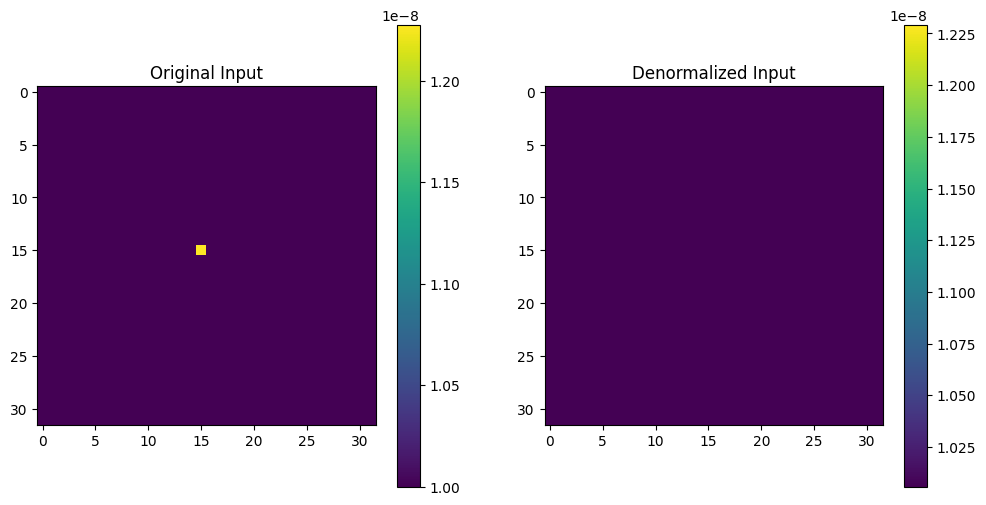

In [202]:
import matplotlib.pyplot as plt

# Choose a variable to visualize
var_idx = 0

# Plot the original input data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Input")
plt.imshow(output_data[0,:,:,0], cmap='viridis')
plt.colorbar()

# Plot the denormalized input data
plt.subplot(1, 2, 2)
plt.title("Denormalized Input")
plt.imshow(denormalized_output[0,:,:,0].detach(), cmap='viridis')
plt.colorbar()

plt.show()


In [196]:
input_data.shape

torch.Size([61, 32, 32, 6])

In [159]:
input_data, output_data = dataset[0]

In [161]:
output_data.shape

torch.Size([61, 32, 32, 1])

In [162]:
input_data.shape

torch.Size([61, 32, 32, 6])

In [169]:
dataset.input_normalizers

[]

In [47]:
encoded_input_data = normalizers[0].encode(input_data)

In [43]:
encoded_input_data = []
for i, input_item in enumerate(input_data):
    normalizer = normalizers[i]
    encoded_input_item = normalizer.encode(input_item)
    encoded_input_data.append(encoded_input_item)


In [44]:
decoded_input_data = []
for i, encoded_input_item in enumerate(encoded_input_data):
    normalizer = normalizers[i]
    decoded_input_item = normalizer.decode_with_values(encoded_input_item, normalizer.mean, normalizer.std)
    decoded_input_data.append(decoded_input_item)


In [32]:

input_data, output_data, normalizers = dataset[0]
dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=4)

for batch_idx, (inputs, targets) in enumerate(dataloader):
    print(f'Batch index: {batch_idx}')
    print(f'Inputs shape: {inputs.shape}')
    print(f'Targets shape: {targets.shape}')
    if batch_idx == 3: 
        break

Batch index: 0
Inputs shape: torch.Size([10, 61, 32, 32, 6])
Targets shape: torch.Size([10, 61, 32, 32, 1])
Batch index: 1
Inputs shape: torch.Size([10, 61, 32, 32, 6])
Targets shape: torch.Size([10, 61, 32, 32, 1])
Batch index: 2
Inputs shape: torch.Size([10, 61, 32, 32, 6])
Targets shape: torch.Size([10, 61, 32, 32, 1])
Batch index: 3
Inputs shape: torch.Size([10, 61, 32, 32, 6])
Targets shape: torch.Size([10, 61, 32, 32, 1])


In [10]:
def show_sample(norm_sample, dataset):
    input_data, output_data = norm_sample
    
    # Decode normalization
    decoded_input = dataset.input_normalizer.decode(input_data)
    decoded_output = dataset.output_normalizer.decode(output_data)
    
    plt.imshow(decoded_input[0], cmap='gray')  # [0] accesses the first channel
    plt.title('Label: ' + str(decoded_output))
    plt.show()

# ...

for batch_idx, (norm_data) in enumerate(dataloader):
    # Visualize the first sample in each batch
    show_sample(norm_data, dataset)
    if batch_idx == 3:  # show only first 4 batches
        break


AttributeError: 'ReadXarrayDataset' object has no attribute 'input_normalizer'

Batch index: 0
Inputs shape: torch.Size([10, 61, 32, 32, 6])
Targets shape: torch.Size([10, 61, 32, 32, 1])
Batch index: 1
Inputs shape: torch.Size([10, 61, 32, 32, 6])
Targets shape: torch.Size([10, 61, 32, 32, 1])
Batch index: 2
Inputs shape: torch.Size([10, 61, 32, 32, 6])
Targets shape: torch.Size([10, 61, 32, 32, 1])
Batch index: 3
Inputs shape: torch.Size([10, 61, 32, 32, 6])
Targets shape: torch.Size([10, 61, 32, 32, 1])


In [150]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Read dataset

In [173]:
class ReadXarrayDataset():
    def __init__(self, folder, input_vars, output_vars, device='cpu', num_files=None, traintest_split= 0.8):
        self.folder = folder        
        self.file_list = os.listdir(folder)[:num_files] if num_files else os.listdir(folder)            
        self.input_vars = input_vars.copy()
        self.input_vars.append('x_encoding')
        self.input_vars.append('y_encoding')
        self.input_vars.append('time_encoding')
        self.output_vars = output_vars
        self.device = device
        
        input_data_list = []
        output_data_list = []
        
        #iterate inside the folder
        for i in range(len(self.file_list)):
            file_path = os.path.join(self.folder, self.file_list[i])
            data = xr.open_dataset(file_path)
            
            # Add the meshgrids as new data variables in the xarray
            X = data['X'].values
            Y = data['Y'].values
            TIME = data['time'].values

            # Create meshgrids for X and Y dimensions
            x_mesh, y_mesh = np.meshgrid(data.X, data.Y, indexing='ij')
            TIME_MESH = np.meshgrid(data.time, data.X, data.Y, indexing='ij')
            data = data.assign(x_encoding=xr.DataArray(x_mesh, coords=[("X", X), ("Y", Y)]))
            data = data.assign(y_encoding=xr.DataArray(y_mesh, coords=[("X", X), ("Y", Y)]))
            data = data.assign(time_encoding=xr.DataArray(TIME_MESH[0], coords=[("time", TIME), ("X", X), ("Y", Y)]))

            # Append input variables to list
            input_data = []
            for var in self.input_vars:
                if 'time' in data[var].dims:
                    input_data.append(torch.tensor(data[var].values, dtype=torch.float32))
                else:
                    scalar_matrix = torch.tensor(data[var].values, dtype=torch.float32).expand(data.time.size, -1, -1)
                    input_data.append(scalar_matrix)

            # Append output variables to list
            output_data = []
            for var in self.output_vars:
                output_data.append(torch.tensor(data[var].values, dtype=torch.float32))

            # Concatenate input variables along new dimension
            input_data_list.append(torch.stack(input_data, dim=-1))

            # Concatenate output variables along new dimension
            output_data_list.append(torch.stack(output_data, dim=-1))

        # Concatenate input variables along new dimension
        input_data = torch.stack(input_data_list, dim=0)

        # Concatenate output variables along new dimension
        output_data = torch.stack(output_data_list, dim=0)

        # Swap order of time and channel dimensions
        input_data = input_data.permute(0,1, 2, 3, 4)
        output_data = output_data.permute(0,1, 2, 3, 4)

        self.input_data = input_data
        self.output_data = output_data

        # Split data into training and testing sets
        self.train_size = int(traintest_split * len(self.file_list))
        self.test_size = len(self.file_list) - self.train_size
        
        self.train_data_input, self.test_data_input = torch.split(self.input_data, [self.train_size, self.test_size], dim=0)
        self.train_data_output, self.test_data_output = torch.split(self.output_data, [self.train_size, self.test_size], dim=0)




# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001, time_last=True):
        super(UnitGaussianNormalizer, self).__init__()

        self.mean = torch.mean(x, dim=(0, 1, 2))
        self.std = torch.std(x, dim=(0, 1, 2))
        self.eps = eps


    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x):
        std = self.std + self.eps # n
        mean = self.mean
        x = (x * std) + mean
        return x




In [2]:
folder = "/scratch/smrserraoseabr/Projects/FluvialCO2/results32"
input_vars = ['Por', 'Perm', 'Pressure'] # Porosity, Permeability, Pressure + x, y, time encodings 
output_vars = ['CO_2']

# Create instance of ReadXarrayDataset class
dataset = ReadXarrayDataset(folder=folder, input_vars=input_vars, output_vars=output_vars, num_files=100)

# Get input and output data tensors
input_data = dataset.train_data_input
output_data = dataset.train_data_output

# Print shapes of input and output data tensors
print("Input data shape:", input_data.shape)
print("Output data shape:", output_data.shape)

# Move data tensors to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_data = input_data.to(device)
output_data = output_data.to(device)

NameError: name 'ReadXarrayDataset' is not defined

Normalize dataset

In [175]:
# Normalize input_data and output_data
train_a = input_data
train_u = output_data
a_normalizer = UnitGaussianNormalizer(train_a)
train_a_normalized = a_normalizer.encode(train_a)
y_normalizer = UnitGaussianNormalizer(train_u)
train_u_normalized = y_normalizer.encode(train_u)

#print shapes of normalized data
print("Normalized input data shape:", train_a_normalized.shape)
print("Normalized output data shape:", train_u_normalized.shape)


# Denormalize the normalized data
train_a_denormalized = a_normalizer.decode(train_a_normalized)
train_u_denormalized = y_normalizer.decode(train_u_normalized)

# Check if the original data and the denormalized data are the same
input_data_error = torch.mean((train_a - train_a_denormalized)**2).item()
output_data_error = torch.mean((train_u - train_u_denormalized)**2).item()

print("Input data error: ", input_data_error)
print("Output data error: ", output_data_error)

# Check if the errors are within an acceptable tolerance
tolerance = 1e-6
assert input_data_error < tolerance, "Input data denormalization error is too high"
assert output_data_error < tolerance, "Output data denormalization error is too high"

print("Encode and decode functions are working properly")


Normalized input data shape: torch.Size([80, 61, 32, 32, 6])
Normalized output data shape: torch.Size([80, 61, 32, 32, 1])
Input data error:  1.4038546367056703e-11
Output data error:  2.352432268079574e-12
Encode and decode functions are working properly


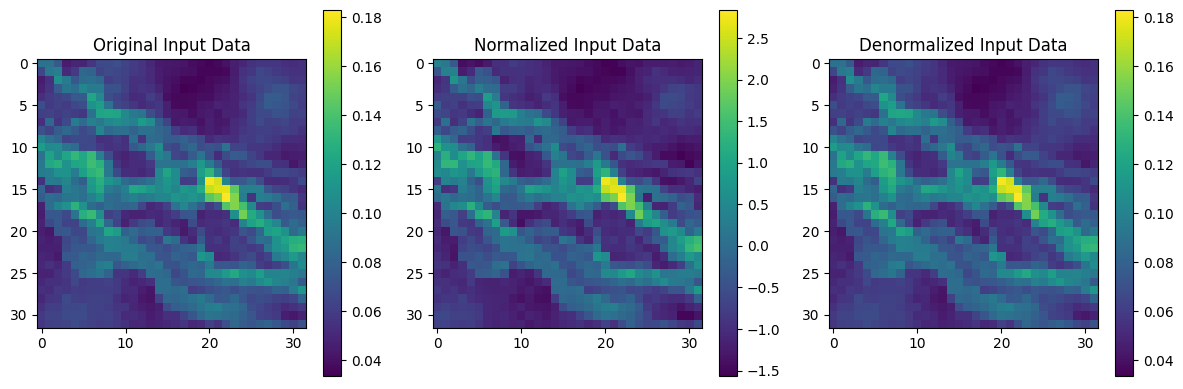

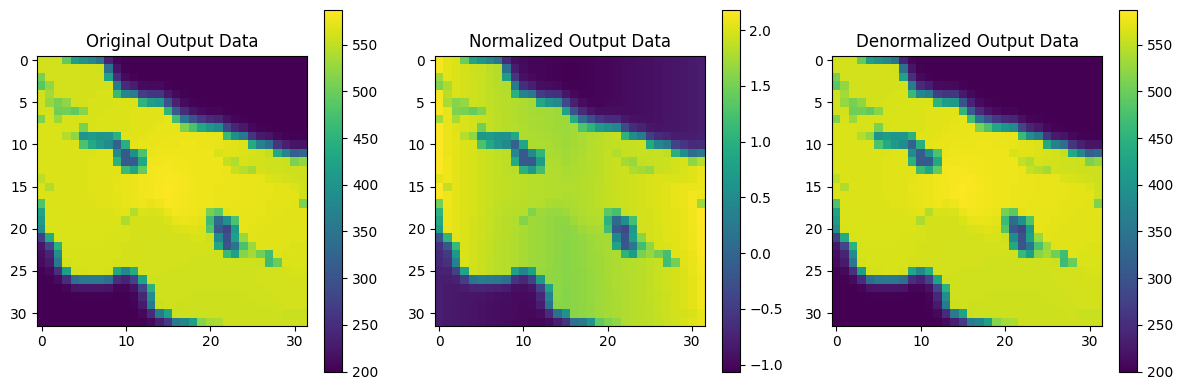

In [176]:
import matplotlib.pyplot as plt

# Select the first sample and the first channel to visualize
sample_idx = 0
channel_idx = 0
time_step = 60

# Original input data
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(train_a[sample_idx, time_step, :, : , channel_idx], cmap='viridis')
plt.title("Original Input Data")
plt.colorbar()

# Normalized input data
plt.subplot(132)
plt.imshow(train_a_normalized[sample_idx, time_step, :, : , channel_idx], cmap='viridis')
plt.title("Normalized Input Data")
plt.colorbar()

# Denormalized input data
plt.subplot(133)
plt.imshow(train_a_denormalized[sample_idx, time_step, :, : , channel_idx], cmap='viridis')
plt.title("Denormalized Input Data")
plt.colorbar()

plt.tight_layout()
plt.show()

# Original output data
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(train_u[sample_idx, time_step, :, : , channel_idx], cmap='viridis')
plt.title("Original Output Data")
plt.colorbar()

# Normalized output data
plt.subplot(132)
plt.imshow(train_u_normalized[sample_idx, time_step, :, : , channel_idx], cmap='viridis')
plt.title("Normalized Output Data")
plt.colorbar()

# Denormalized output data
plt.subplot(133)
plt.imshow(train_u_denormalized[sample_idx, time_step, :, : , channel_idx], cmap='viridis')
plt.title("Denormalized Output Data")
plt.colorbar()

plt.tight_layout()
plt.show()


Preparing data for DataLoader

In [177]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create instance of ReadXarrayDataset class for training data
dataset = ReadXarrayDataset(folder=folder, input_vars=input_vars, output_vars=output_vars, num_files=100)


# Get input and output data tensors
train_a = dataset.train_data_input
train_u = dataset.train_data_output

test_a = dataset.test_data_input
test_u = dataset.test_data_output

# Move data tensors to GPU if available
train_a = train_a.to(device)
train_u = train_u.to(device)

test_a = test_a.to(device)
test_u = test_u.to(device)

# Normalize input_data and output_data
a_normalizer = UnitGaussianNormalizer(train_a)
train_a= a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)

y_normalizer = UnitGaussianNormalizer(train_u)
train_u = y_normalizer.encode(train_u)
test_u = y_normalizer.encode(test_u)

#print shapes of normalized input and output data tensors
print("Train input data shape:", train_a.shape)
print("Train output data shape:", train_u.shape)
print("Test input data shape:", test_a.shape)
print("Test output data shape:", test_u.shape)





Train input data shape: torch.Size([80, 61, 32, 32, 6])
Train output data shape: torch.Size([80, 61, 32, 32, 1])
Test input data shape: torch.Size([20, 61, 32, 32, 6])
Test output data shape: torch.Size([20, 61, 32, 32, 1])


In [180]:
batch_size = 5
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

In [181]:
def check_loader(loader, loader_name):
    print(f"Checking {loader_name}:")
    for i, (input_batch, output_batch) in enumerate(loader):
        print(f"Batch {i+1}:")
        print(f"  Input shape: {input_batch.shape}")
        print(f"  Output shape: {output_batch.shape}")
        print(f"  Input min: {input_batch.min().item()}, max: {input_batch.max().item()}, mean: {input_batch.mean().item()}, std: {input_batch.std().item()}")
        print(f"  Output min: {output_batch.min().item()}, max: {output_batch.max().item()}, mean: {output_batch.mean().item()}, std: {output_batch.std().item()}")

        # Stop checking after a few batches
        if i >= 2:
            break

check_loader(train_loader, "train_loader")
print("\n")
check_loader(test_loader, "test_loader")


Checking train_loader:
Batch 1:
  Input shape: torch.Size([5, 61, 32, 32, 6])
  Output shape: torch.Size([5, 61, 32, 32, 1])
  Input min: -36.62109375, max: 61.03515625, mean: 0.20817844569683075, std: 8.899795532226562
  Output min: -1.061406135559082, max: 2.2438924312591553, mean: 0.058120645582675934, std: 1.0162140130996704
Batch 2:
  Input shape: torch.Size([5, 61, 32, 32, 6])
  Output shape: torch.Size([5, 61, 32, 32, 1])
  Input min: -36.62109375, max: 61.03515625, mean: 0.25190210342407227, std: 8.894315719604492
  Output min: -1.061406135559082, max: 2.324021339416504, mean: 0.43104973435401917, std: 1.0992246866226196
Batch 3:
  Input shape: torch.Size([5, 61, 32, 32, 6])
  Output shape: torch.Size([5, 61, 32, 32, 1])
  Input min: -36.62109375, max: 61.03515625, mean: 0.1468278020620346, std: 8.884174346923828
  Output min: -1.061406135559082, max: 2.081953525543213, mean: 0.06372862309217453, std: 0.9610589146614075


Checking test_loader:
Batch 1:
  Input shape: torch.Size

##Reading from the zip file - Still need to figure out how to read from the zip file

In [31]:
import zipfile
import io
class XarrayDataset(Dataset):
    def __init__(self, zip_file_path, input_vars, output_vars):
        self.zip_file_path = zip_file_path
        self.input_vars = input_vars
        self.input_vars.append('x_encoding')
        self.input_vars.append('y_encoding')
        self.input_vars.append('time_encoding')
        self.output_vars = output_vars

        with zipfile.ZipFile(self.zip_file_path, 'r') as zip_ref:
            self.file_list = [f for f in zip_ref.namelist() if f.endswith('.nc')]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        with zipfile.ZipFile(self.zip_file_path, 'r') as zip_ref:
            file_path = self.file_list[idx]
            with zip_ref.open(file_path, 'r') as file:
                data = xr.open_dataset(io.BytesIO(file.read()) , engine='scipy')
        # Add the meshgrids as new data variables in the xarray
        X = data['X'].values
        Y = data['Y'].values
        TIME = data['time'].values

        # Create meshgrids for X and Y dimensions
        x_mesh, y_mesh = np.meshgrid(data.X, data.Y, indexing='ij')
        TIME_MESH = np.meshgrid(data.time, data.X, data.Y, indexing='ij')
        data = data.assign(x_encoding=xr.DataArray(x_mesh, coords=[("X", X), ("Y", Y)]))
        data = data.assign(y_encoding=xr.DataArray(y_mesh, coords=[("X", X), ("Y", Y)]))
        data = data.assign(time_encoding=xr.DataArray(TIME_MESH[0], coords=[("time", TIME), ("X", X), ("Y", Y)]))

        # Concatenate input variables along a new dimension
        input_data_list = []
        for var in self.input_vars:
            if 'time' in data[var].dims:
                input_data_list.append(torch.tensor(data[var].values, dtype=torch.float32).unsqueeze(0))
            else:
                scalar_matrix = torch.tensor(data[var].values, dtype=torch.float32).expand(data.time.size, -1, -1)
                input_data_list.append(scalar_matrix.unsqueeze(0))

        input_data = torch.cat(input_data_list, dim=0)
        input_data = input_data.permute(1, 2, 3, 0)  # Reorder dimensions to (time, shape[0], shape[1], channels)

        # Concatenate output variables along a new dimension
        output_data_list = [torch.tensor(data[var].values, dtype=torch.float32).unsqueeze(0) for var in self.output_vars]
        output_data = torch.cat(output_data_list, dim=0)
        output_data = output_data.permute(1, 2, 3, 0)  # Reorder dimensions to (time, shape[0], shape[1], channels)

        return input_data, output_data

In [77]:
zip_file_path = "/scratch/smrserraoseabr/Projects/FluvialCO2/results32.zip"
input_vars = ['Por', 'Perm']
output_vars = ['Pressure']

# Create a dataset and DataLoader
dataset = XarrayDataset(zip_file_path, input_vars, output_vars)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True, num_workers=1)

# Test the dataloader by loading a few batches
num_batches_to_check = 5
for i, (input_data, output_data) in enumerate(dataloader):
    if i >= num_batches_to_check:
        break

    print(f"Batch {i+1}:")
    print(f"Input data shape: {input_data.shape}")
    print(f"Output data shape: {output_data.shape}")


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/xarray/backends/scipy_.py", line 102, in _open_scipy_netcdf
    return scipy.io.netcdf_file(filename, mode=mode, mmap=mmap, version=version)
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/scipy/io/_netcdf.py", line 277, in __init__
    self._read()
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/scipy/io/_netcdf.py", line 598, in _read
    raise TypeError("Error: %s is not a valid NetCDF 3 file" %
TypeError: Error: None is not a valid NetCDF 3 file

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_2981016/2060069648.py", line 21, in __getitem__
    data = xr.open_dataset(io.BytesIO(file.read()) , engine='scipy')
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/xarray/backends/api.py", line 531, in open_dataset
    backend_ds = backend.open_dataset(
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/xarray/backends/scipy_.py", line 279, in open_dataset
    store = ScipyDataStore(
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/xarray/backends/scipy_.py", line 154, in __init__
    scipy_dataset = _open_scipy_netcdf(
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/xarray/backends/scipy_.py", line 113, in _open_scipy_netcdf
    raise TypeError(errmsg)
TypeError: Error: None is not a valid NetCDF 3 file
            If this is a NetCDF4 file, you may need to install the
            netcdf4 library, e.g.,

            $ pip install netcdf4
            


In [78]:
!pip install netCDF4


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import os
import zipfile
import xarray as xr
import torch
from torch.utils.data import IterableDataset

class XarrayDataset(IterableDataset):
    def __init__(self, zip_file, input_vars_time_varying, input_vars_time_fixed, output_vars):
        self.zip_file = zipfile.ZipFile(zip_file, 'r')
        self.file_list = self.zip_file.namelist()
        self.input_vars_time_varying = input_vars_time_varying
        self.input_vars_time_fixed = input_vars_time_fixed
        self.output_vars = output_vars

    def __len__(self):
        return len(self.file_list)

    def read_xarray_file(self, file_path):
        with self.zip_file.open(file_path) as file:
            data = xr.open_dataset(file, engine='netcdf4', backend_kwargs={'mode': 'r'})

            input_data_time_varying = torch.cat([torch.tensor(data[var].values, dtype=torch.float32).unsqueeze(-1) for var in self.input_vars_time_varying], dim=-1)
            input_data_time_fixed = torch.cat([torch.tensor(data[var].values, dtype=torch.float32).unsqueeze(-1) for var in self.input_vars_time_fixed], dim=-1)
            output_data = torch.cat([torch.tensor(data[var].values, dtype=torch.float32).unsqueeze(-1) for var in self.output_vars], dim=-1)

        return input_data_time_varying, input_data_time_fixed, output_data

    def __iter__(self):
        for file_path in self.file_list:
            yield self.read_xarray_file(file_path)


In [10]:
#read from the zip folder
class XarrayDatasetZip(Dataset):
    def __init__(self, zip_file, input_vars, output_vars):
        self.zip_file = zipfile.ZipFile(zip_file, 'r')
        self.file_list = self.zip_file.namelist()
        self.input_vars = input_vars
        self.output_vars = output_vars


    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]

        # Read xarray file directly from the zip file
        with self.zip_file.open(file_path) as file:
            data = xr.open_dataset(file, engine='netcdf4', backend_kwargs={'mode': 'r'})



            # Concatenate input variables along a new dimension
            input_data = torch.cat([torch.tensor(data[var].values, dtype=torch.float32).unsqueeze(-1) for var in input_vars], dim=-1)

            # Concatenate output variables along a new dimension
            output_data = torch.cat([torch.tensor(data[var].values, dtype=torch.float32).unsqueeze(-1) for var in output_vars], dim=-1)

        return input_data, output_data

In [35]:
class XarrayDatasetZipIter(IterableDataset):
    def __init__(self, zip_file, input_vars, output_vars):
        self.zip_file = zipfile.ZipFile(zip_file, 'r')
        self.file_list = self.zip_file.namelist()
        self.input_vars = input_vars
        self.output_vars = output_vars

    def __len__(self):
        return len(self.file_list)

    def read_xarray_file(self, file_path):
        with self.zip_file.open(file_path) as file:
            data = xr.open_dataset(file, backend_kwargs={'mode': 'r'})



            input_data = torch.cat([torch.tensor(data[var].values, dtype=torch.float32).unsqueeze(-1) for var in input_vars], dim=-1)
            output_data = torch.cat([torch.tensor(data[var].values, dtype=torch.float32).unsqueeze(-1) for var in output_vars], dim=-1)

        return input_data, output_data

    def __iter__(self):
        for file_path in self.file_list:
            yield self.read_xarray_file(file_path)

In [36]:
""""
Note that we set batch_size=None in the DataLoader. This is because IterableDataset does not support automatic batching, so you'll need to handle batching manually in your training loop.
"""
input_vars = ['Por', 'Perm']
output_vars = ['GasSat', 'Pressure', 'CO_2']
folder_zip="/scratch/smrserraoseabr/Projects/FluvialCO2/results32.zip"
#dataset = XarrayDataset(folder, input_vars, output_vars)
#dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
dataset = XarrayDatasetZipIter(folder_zip, input_vars, output_vars)
dataloader = DataLoader(dataset, batch_size=None, num_workers=4)

In [37]:
# Test the dataloader by loading a few batches
num_batches_to_check = 5

for i, (input_data, output_data) in enumerate(dataloader):
    print(f"Batch {i+1}:")
    print(f"Input data shape: {input_data.shape}")
    print(f"Output data shape: {output_data.shape}")
    print(f"Input data: {input_data}")
    print(f"Output data: {output_data}")
    print("\n")

    if i >= num_batches_to_check - 1:
        break


ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 39, in fetch
    data = next(self.dataset_iter)
  File "/tmp/ipykernel_2941125/2706523513.py", line 24, in __iter__
    yield self.read_xarray_file(file_path)
  File "/tmp/ipykernel_2941125/2706523513.py", line 13, in read_xarray_file
    data = xr.open_dataset(file, backend_kwargs={'mode': 'r'})
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/xarray/backends/api.py", line 515, in open_dataset
    engine = plugins.guess_engine(filename_or_obj)
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/xarray/backends/plugins.py", line 155, in guess_engine
    raise ValueError(error_msg)
ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html


In [30]:
dataloader

In [ ]:
""""
def train_epoch(dataloader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    n_batches = 0

    batch_inputs = []
    batch_outputs = []
    batch_size = 32

    for inputs, outputs in dataloader:
        batch_inputs.append(inputs.to(device))
        batch_outputs.append(outputs.to(device))

        if len(batch_inputs) == batch_size:
            inputs_batch = torch.stack(batch_inputs)
            outputs_batch = torch.stack(batch_outputs)

            optimizer.zero_grad()
            predictions = model(inputs_batch)
            loss = criterion(predictions, outputs_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            n_batches += 1

            batch_inputs.clear()
            batch_outputs.clear()

    return running_loss / n_batches
"""

In [ ]:
import zipfile
import torch
from torchvision import transforms
from PIL import Image
import io

def load_image_from_zip(zip_path, file_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open(file_path) as f:
            img = Image.open(io.BytesIO(f.read()))
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ])
            img_tensor = transform(img)
            return img_tensor

zip_path = "path/to/your/zipfile.zip"
file_path = "path/to/your/image.jpg"

img_tensor = load_image_from_zip(zip_path, file_path)
print(img_tensor.shape)


In [15]:
import zipfile
import xarray as xr
import torch
from torch.utils.data import IterableDataset



In [16]:
zip_path = r'/scratch/smrserraoseabr/Projects/FluvialCO2/results32.zip'

In [18]:
zip_file = zipfile.ZipFile(zip_path, 'r')
    

In [21]:
len(zip_file.namelist()[1:])

1000

In [24]:
zipfile.ZipFile(zip_path, 'r')

<zipfile.ZipFile filename='/scratch/smrserraoseabr/Projects/FluvialCO2/results32.zip' mode='r'>

In [25]:
with zip_file.open(file_path) as file:
        data = xr.open_dataset(file, engine='netcdf4', backend_kwargs={'mode': 'r'})




NameError: name 'file_path' is not defined

In [ ]:
file_list = zip_file.namelist()